In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.__version__
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

2.1.0+cu121 True


In [ ]:
!pip show pyyaml
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git' &> /dev/null

Name: PyYAML
Version: 6.0.1
Summary: YAML parser and emitter for Python
Home-page: https://pyyaml.org/
Author: Kirill Simonov
Author-email: xi@resolvent.net
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: albumentations, astropy, bokeh, dask, distributed, fastai, flax, huggingface-hub, llmx, orbax-checkpoint, pins, PyDrive, PyDrive2, transformers


In [ ]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer,ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_train_loader
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper   # the default mapper

In [ ]:
# MetadataCatalog.remove("sk_keypoints_train")
# DatasetCatalog.remove("sk_keypoints_train")
# MetadataCatalog.remove("sk_keypoints_val")
# DatasetCatalog.remove("sk_keypoints_val")

In [ ]:
train_img_dir="/content/drive/MyDrive/Dataset/aspine20230930/image_train"
train_annotations_file="/content/drive/MyDrive/Dataset/aspine20230930/annotations/person_keypoints_Train.json"
val_img_dir="/content/drive/MyDrive/Dataset/aspine20230930/image_val"
val_annotations_file="/content/drive/MyDrive/Dataset/aspine20230930/annotations/person_keypoints_Validation.json"

In [ ]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("sk_keypoints_train", {}, train_annotations_file, train_img_dir)
register_coco_instances("sk_keypoints_val", {}, val_annotations_file, val_img_dir)

In [ ]:
keypoint_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16']
keypoint_flip_map = []
# keypoint_connection_rules = [('left_eye', 'left_eye', (102, 204, 255)),('nose', 'left_eye', (102, 204, 255)),('nose', 'right_eye', (102, 204, 255))]

In [ ]:
from detectron2.data import MetadataCatalog

MetadataCatalog.get("sk_keypoints_train").thing_classes = ["pelvis16"]
MetadataCatalog.get("sk_keypoints_train").thing_dataset_id_to_contiguous_id = {1:0}
MetadataCatalog.get("sk_keypoints_train").evaluator_type="coco"
MetadataCatalog.get("sk_keypoints_train").keypoint_names = keypoint_names
MetadataCatalog.get("sk_keypoints_train").keypoint_flip_map = keypoint_flip_map
MetadataCatalog.get("sk_keypoints_val").thing_classes = ["pelvis16"]
MetadataCatalog.get("sk_keypoints_val").thing_dataset_id_to_contiguous_id = {1:0}
MetadataCatalog.get("sk_keypoints_val").evaluator_type="coco"

In [ ]:
sk_metadata = MetadataCatalog.get("sk_keypoints_train")

In [ ]:
dataset_dicts = DatasetCatalog.get("sk_keypoints_train")

[02/17 14:57:19 d2.data.datasets.coco]: Loaded 188 images in COCO format from /content/drive/MyDrive/Dataset/aspine20230930/annotations/person_keypoints_Train.json


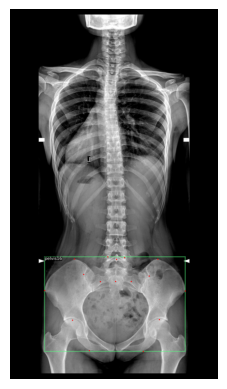

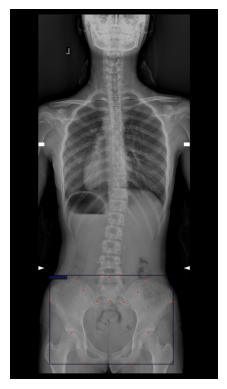

In [ ]:
# To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the dataset:
import random
from detectron2.utils.visualizer import Visualizer

def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off');

for d in random.sample(dataset_dicts, 2):
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], metadata=sk_metadata, scale=2)
  vis = visualizer.draw_dataset_dict(d)
  cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.MODEL.DEVICE = "cuda"

cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/Base-Keypoint-RCNN-FPN.yaml"))
cfg.DATASETS.TRAIN = ("sk_keypoints_train",)
cfg.OUTPUT_DIR = '/content/drive/MyDrive/Dataset/output'
cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/Dataset/output/model_final.pth'

#cfg.DATASETS.TEST = ("hand_test",)  #Dataset 'hand_test' is empty in my case
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 32
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final_train.pth")

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300   # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   #128   # faster, and good enough for this toy dataset (default: 512)

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # person
cfg.MODEL.RETINANET.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 16
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.TEST.KEYPOINT_OKS_SIGMAS = np.ones((3, 1), dtype=float).tolist()


In [ ]:
class Trainer(DefaultTrainer):
    """
    We use the "DefaultTrainer" which contains a number pre-defined logic for
    standard training workflow. They may not work for you, especially if you
    are working on a new research project. In that case you can use the cleaner
    "SimpleTrainer", or write your own training loop.
    """
    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(cfg, is_train=True, augmentations=[])
        return build_detection_train_loader(cfg, mapper=mapper)

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg)    #CocoTrainer(cfg)
trainer.train()

[02/17 15:16:12 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.10/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor 

[02/17 15:16:45 d2.utils.events]:  eta: 0:06:19  iter: 19  total_loss: 53.53  loss_cls: 17.1  loss_box_reg: 1.024  loss_keypoint: 37.66  loss_rpn_cls: 0.18  loss_rpn_loc: 0.6791    time: 1.3833  last_time: 1.6559  data_time: 0.1539  last_data_time: 0.0543   lr: 1.6068e-05  max_mem: 9665M
[02/17 15:17:12 d2.utils.events]:  eta: 0:05:52  iter: 39  total_loss: 10.76  loss_cls: 3.483  loss_box_reg: 0.1342  loss_keypoint: 6.744  loss_rpn_cls: 0.04801  loss_rpn_loc: 0.0975    time: 1.3776  last_time: 1.2965  data_time: 0.0142  last_data_time: 0.0329   lr: 3.2718e-05  max_mem: 9665M
[02/17 15:17:38 d2.utils.events]:  eta: 0:05:21  iter: 59  total_loss: 7.829  loss_cls: 0.9057  loss_box_reg: 0.02121  loss_keypoint: 6.97  loss_rpn_cls: 0.02487  loss_rpn_loc: 0.02601    time: 1.3517  last_time: 1.3138  data_time: 0.0219  last_data_time: 0.0146   lr: 4.9367e-05  max_mem: 9665M
[02/17 15:18:05 d2.utils.events]:  eta: 0:04:54  iter: 79  total_loss: 7.979  loss_cls: 0.6077  loss_box_reg: 0.04637  lo

In [ ]:
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/Base-Keypoint-RCNN-FPN.yaml"))
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/Dataset/output/model_final.pth'  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 16

predictor = DefaultPredictor(cfg)

[02/17 15:26:57 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Dataset/output/model_final.pth ...


In [ ]:
im = cv2.imread("/content/drive/MyDrive/Dataset/aspine20230930/image_val/img-00020-00001.jpg")
outputs = predictor(im)
print(outputs["instances"])

Instances(num_instances=1, image_height=2112, image_width=1184, fields=[pred_boxes: Boxes(tensor([[ 127.7762, 1488.4462, 1028.4718, 2110.7676]], device='cuda:0')), scores: tensor([0.9648], device='cuda:0'), pred_classes: tensor([0], device='cuda:0'), pred_keypoints: tensor([[[3.7076e+02, 1.5209e+03, 6.1670e-02],
         [8.4722e+02, 1.5193e+03, 6.4715e-02],
         [2.3937e+02, 1.6112e+03, 2.0694e-02],
         [9.8177e+02, 1.6333e+03, 3.4187e-02],
         [5.0214e+02, 1.6539e+03, 1.6452e-01],
         [6.9368e+02, 1.6223e+03, 2.0617e-01],
         [4.6573e+02, 1.5589e+03, 5.9655e-02],
         [7.6808e+02, 1.5747e+03, 9.6671e-02],
         [5.9870e+02, 1.6112e+03, 7.8889e-02],
         [3.8659e+02, 1.7949e+03, 6.3470e-02],
         [8.7413e+02, 1.8218e+03, 6.0141e-02],
         [4.6732e+02, 1.9912e+03, 6.2641e-02],
         [7.5700e+02, 2.0134e+03, 4.2637e-02],
         [5.6388e+02, 1.4908e+03, 1.4503e-01],
         [6.5885e+02, 1.5193e+03, 1.7482e-01],
         [6.2403e+02, 1.5146

In [ ]:
list(outputs['instances'].pred_keypoints)

[tensor([[3.7076e+02, 1.5209e+03, 6.1670e-02],
         [8.4722e+02, 1.5193e+03, 6.4715e-02],
         [2.3937e+02, 1.6112e+03, 2.0694e-02],
         [9.8177e+02, 1.6333e+03, 3.4187e-02],
         [5.0214e+02, 1.6539e+03, 1.6452e-01],
         [6.9368e+02, 1.6223e+03, 2.0617e-01],
         [4.6573e+02, 1.5589e+03, 5.9655e-02],
         [7.6808e+02, 1.5747e+03, 9.6671e-02],
         [5.9870e+02, 1.6112e+03, 7.8889e-02],
         [3.8659e+02, 1.7949e+03, 6.3470e-02],
         [8.7413e+02, 1.8218e+03, 6.0141e-02],
         [4.6732e+02, 1.9912e+03, 6.2641e-02],
         [7.5700e+02, 2.0134e+03, 4.2637e-02],
         [5.6388e+02, 1.4908e+03, 1.4503e-01],
         [6.5885e+02, 1.5193e+03, 1.7482e-01],
         [6.2403e+02, 1.5146e+03, 8.5894e-02]], device='cuda:0')]

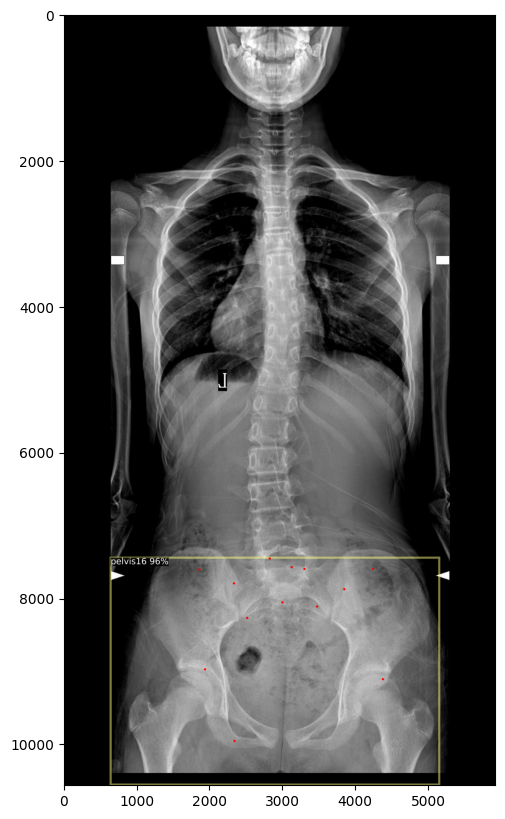

In [ ]:
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
v = Visualizer(im[:, :, ::-1],metadata=sk_metadata,scale=5,
)


v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

# o = outputs["instances"]
# #Create new class, boxes, scores & masks
# classes = o.pred_classes[idxofClass]
# scores = o.scores[idxofClass]
# boxes = o.pred_boxes[idxofClass]
# #masks = o.pred_masks[idxofClass]

# #Define new instance and set the new values to new instance. Note: detectron2 module provides this method set.
# obj = detectron2.structures.Instances(image_size=(480, 640))

# obj.set('pred_classes', classes)
# obj.set('scores', scores)
# obj.set('pred_boxes', boxes)

# obj